In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

In [2]:
import os, sys
sys.path.append('../functions')

# Read Data

In [3]:
data = pandas.read_csv('Data/hits.csv', index_col=0)
data['IsStereo'] = (data.ViewNb.values == 1) * 1. + (data.ViewNb.values == 2) * 1.

data.head()

,EventID,TrackID,PdgCode,DetectorID,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Px,...,Wx2,Wy1,Wy2,Wz,Wz1,Wz2,Label,Time,ELoss,IsStereo
79,2,2,-211,10002284,1,0,0,0,284,0.866347,...,250.000000,0.868600,0.868600,2581.1500,2581.1500,2581.1500,0,383.880371,5.310523e-06,0
111,2,2,-211,42012282,4,2,0,1,282,0.867240,...,249.507863,27.037487,-16.540384,3542.3793,3542.3793,3542.3793,0,415.954742,5.271870e-07,1
81,2,2,-211,11012288,1,1,0,1,288,0.866625,...,249.509850,-27.060200,16.517671,2592.3793,2592.3793,2592.3793,0,384.254303,3.097434e-06,1
43,2,3,-13,11012286,1,1,0,1,286,-0.239448,...,249.203062,-23.553595,20.024276,2592.3793,2592.3793,2592.3793,1,384.251007,3.362202e-06,1
88,2,2,-211,20012285,2,0,0,1,285,0.866401,...,250.000000,-0.011400,-0.011400,2782.2500,2782.2500,2782.2500,0,390.597870,1.754228e-06,0


# Tracks Reconstruction

In [4]:
from baseline import SimpleTemplateMatching
from hough import LinearHoughModel
from reconstruction import TracksReconstruction2D
from combination import Combinator
from retina import Retina2DTrackerOne


from metrics import TracksReconstractionMetrics, CombinatorQuality

### Tests

In [312]:
__author__ = 'mikhail91'

import numpy
import pandas
from sklearn.linear_model import LinearRegression

class ImprovedTemplateMatching(object):

    def __init__(self, n_max_hits, n_min_hits, window_width):
        """
        This class is simple realization of a Template Matching paradigm for straight tracks in 2D.
        :param n_max_hits: int, max min number of hits to consider the track recognized.
        :param n_min_hits: int, min min number of hits to consider the track recognized.
        :param window_width: float, width of a searching window for searching hits for a track.
        :return:
        """

        self.window_width = window_width
        self.n_max_hits = n_max_hits
        self.n_min_hits = n_min_hits

    def fit(self, x, y, sample_weight=None):
        """
        Fit the method.
        :param x: numpy.ndarray shape=[n_hits, n_features], X of hits.
        :param y: numpy.array shape=[n_hits], y of hits.
        :param sample_weight: numpy.array shape=[n_hits], weight of each hits.
        :return:
        """

        used = numpy.zeros(len(x))
        labels = -1. * numpy.ones(len(x))
        track_id = 0
        tracks_params = []
        tracks = []

        #for n_hits in range(self.n_min_hits, self.n_max_hits+1)[::-1]:

        for first_ind in range(len(x)):

            for second_ind in range(len(x)):

                x1 = x[first_ind]
                y1 = y[first_ind]

                x2 = x[second_ind]
                y2 = y[second_ind]

                if (x1 >= x2) or (used[first_ind] == 1) or (used[second_ind] == 1):
                    continue

                k = 1. * (y2 - y1) / (x2 - x1)
                b = y1 - k * x1

                y_upper = b + k * x.reshape(-1) + self.window_width
                y_lower = b + k * x.reshape(-1) - self.window_width

                track = (y <= y_upper) * (y >= y_lower) * (used == 0)

                track_x = x[track]
                track_y = y[track]
                track_index = numpy.arange(len(x))[track]

                [k, b] = numpy.polyfit(track_x, track_y, 1)
                dist = (track_y - track_x * k - b)**2

                unique_x = numpy.unique(track_x)
                new_track_index = []

                for x_one in unique_x:

                    ind_one = track_index[track_x == x_one]
                    dist_one = dist[track_x == x_one]

                    new_ind_one = ind_one[(dist_one == dist_one.min())][0]

                    new_track_index.append(new_ind_one)

                new_track_index = numpy.array(new_track_index)

                track = numpy.in1d(range(len(x)), new_track_index)


                if track.sum() >= self.n_min_hits:

                    #used[track] = 1
                    tracks.append(track)
                    labels[track] = track_id
                    track_id += 1

                    x_track = x[track]
                    y_track = y[track]

                    if sample_weight != None:
                        sample_weight_track = sample_weight[track]
                    else:
                        sample_weight_track = None

                    lr = LinearRegression()
                    lr.fit(x_track.reshape(-1,1), y_track, sample_weight_track)

                    params = list(lr.coef_) + [lr.intercept_]
                    tracks_params.append(params)


        self.labels_ = labels
        self.tracks_params_ = numpy.array(tracks_params)
        self.tracks_ = numpy.array(tracks)


In [705]:
event = data[data.EventID == 558]
event12 = event[(event.StatNb <= 2)*(event.ViewNb != 1)*(event.ViewNb != 2)]

x = event12.Wz1.values
y = event12.Wy1.values

In [723]:
%%time
rt = ImprovedTemplateMatching(n_max_hits=16, n_min_hits=7, window_width=0.75)

rt.fit(x, y)

labels = rt.labels_
tracks_params = rt.tracks_params_

CPU times: user 449 ms, sys: 11.2 ms, total: 460 ms
Wall time: 458 ms


In [724]:
tracks = rt.tracks_

In [725]:
def energy(params, x, y, lambda_=0., T=1.):
        
    params = numpy.array(params)

    beta = 1. / T

    dists = (y - x * params[:, 0].reshape(-1, 1) - params[:, 1].reshape(-1, 1)).T

    E = - 1./beta * (numpy.log(numpy.exp(-beta * lambda_) + numpy.exp(-beta * dists**2).sum(axis=1))).sum()

    return E

In [726]:
Es = []
pr = []
for num1, one in enumerate(tracks_params):
    for num2, two in enumerate(tracks_params):
        
        if num1 == num2:
            continue
        
        
        params = numpy.array([one, two])
        E = energy(params, x, y, lambda_=2.0, T=0.5**2)
        Es.append(E)
        pr.append(params)
        
Es = numpy.array(Es)
pr = numpy.array(pr)

In [727]:
Es

array([ 94.4914729 ,  94.4914729 ,  94.4914729 , ...,  91.66602779,
        91.66602779,  91.66602779])

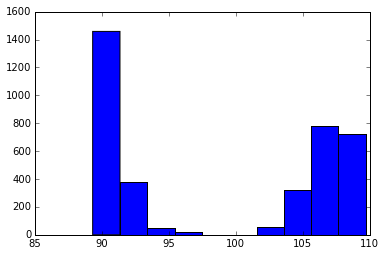

In [728]:
plt.hist(Es, bins=10)
plt.show()

In [729]:
tracks_params2

array([[  2.62932678e-02,   1.17476212e+02],
       [ -5.85685498e-03,   1.40236613e+02]])

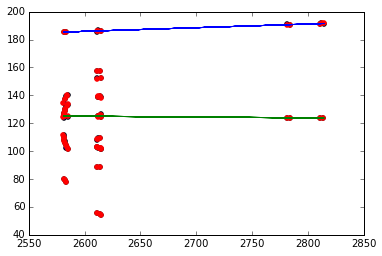

In [730]:
tracks_params2 = pr[Es == Es.min()][0]

plt.scatter(x, y)
for n in range(len(tracks_params2)):
    plt.plot(x, tracks_params2[n][0] * x + tracks_params2[n][1])
    
plt.scatter(event12.Z.values, event12.Y.values, color='r')
plt.show()

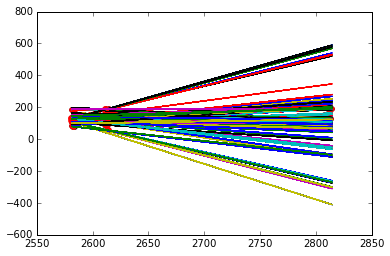

In [722]:
plt.scatter(x, y)
for n in range(len(tracks_params)):
    plt.plot(x, tracks_params[n][0] * x + tracks_params[n][1])
    
plt.scatter(event12.Z.values, event12.Y.values, color='r')
plt.show()

In [365]:
from metrics import HitsMatchingEfficiency

hme = HitsMatchingEfficiency(eff_threshold=0.3)
hme.fit(event12.Label.values, labels)

hme.recognition_efficiency_

1.0

In [366]:
tracks_params

array([[  8.94219653e-03,   6.48656533e+01],
       [  5.39552775e-03,   7.39773803e+01],
       [  5.39552775e-03,   7.39773803e+01],
       [  5.57420897e-03,   7.36284434e+01],
       [  1.05314599e-02,   6.08476472e+01],
       [  6.40315027e-03,   7.14646253e+01],
       [  1.03620253e-02,   6.11721528e+01],
       [  1.05314599e-02,   6.08476472e+01],
       [  1.09718226e-02,   5.93505630e+01],
       [  6.67471872e-03,   7.05507405e+01],
       [  1.21842620e-02,   5.62154613e+01],
       [  7.51023791e-03,   6.83654479e+01],
       [  1.09718226e-02,   5.93505630e+01],
       [  1.21842620e-02,   5.62154613e+01],
       [  8.94219653e-03,   6.48656533e+01],
       [  5.39552775e-03,   7.39773803e+01],
       [  5.39552775e-03,   7.39773803e+01],
       [  5.57420897e-03,   7.36284434e+01],
       [  1.05314599e-02,   6.08476472e+01],
       [  6.40315027e-03,   7.14646253e+01],
       [  1.03620253e-02,   6.11721528e+01],
       [  1.05314599e-02,   6.08476472e+01],
       [  

In [367]:
labels

array([ 58.,  54.,  58.,  54.,  -1.,  52.,  58.,  58.,  58.,  52.,  -1.,
        55.,  58.,  58.,  57.,  58.,  54.,  58.,  58.])

In [368]:
event12.Label.values

array([ 1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,
        0.,  1.,  0.,  1.,  0.,  0.])

### Tracks Reconstruction

In [369]:
%%time
from multiprocessing import Pool
from utils import merge_dicts

event_ids = numpy.unique(data.EventID.values)
tracks = {}

def tracks_reconstruction(event_id):
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    # Select model for the tracks reconstruction
    stm_y = ImprovedTemplateMatching(n_max_hits=16, n_min_hits=7, window_width=0.7)
    stm_stereo = ImprovedTemplateMatching(n_max_hits=16, n_min_hits=6, window_width=15)
    
    # Tracks reconstruction before the magnet
    tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d12.fit(event12, weights12)
    
    labels12 = tr2d12.labels_
    tracks_params12 = tr2d12.tracks_params_
    
    # Tracks reconstruction after the magnet
    tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d34.fit(event34, weights34)
    
    labels34 = tr2d34.labels_
    tracks_params34 = tr2d34.tracks_params_
    
    
    # Save the hits labels and the tracks parameters 
    one_track = {}
    
    one_track[event_id] = {'labels12':labels12, 'params12':tracks_params12, 
                           'labels34':labels34, 'params34':tracks_params34}
    
    return one_track

if __name__ == "__main__":
    p = Pool(3)
    results = p.map(tracks_reconstruction, event_ids[:10])
    tracks = merge_dicts(results)

CPU times: user 18.1 ms, sys: 18.4 ms, total: 36.5 ms
Wall time: 3.01 s


In [370]:
#tracks_reconstruction(2)

In [371]:
%%time

tracks_metrics_before_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

tracks_metrics_after_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

combinations = pandas.DataFrame(columns=['EventID', 'TrackIDBefore', 'TrackIDAfter', 'Charge', 'PInv'])
combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

combinations_quality = pandas.DataFrame(columns=['EventID', 'RecoEff', 'GhostRate', 'CloneRate', 'NCombined'])

pass_stages = pandas.DataFrame(columns=['EventID', 'RecoEvents', 'Y12', 'Stereo12', 'Stations12', 
                                        'Y34', 'Stereo34', 'Stations34', 'Combination', 'Matching'])

for event_id in tracks.keys():
    
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    labels12 = tracks[event_id]['labels12']
    tracks_params12 = tracks[event_id]['params12']
    labels34 = tracks[event_id]['labels34']
    tracks_params34 = tracks[event_id]['params34']
    
    # Select model for the tracks reconstruction
    # stm_y = LinearHoughModel(k_params=(-0.2, 0.2, 0.0004), b_params=(-800, 800, 1.6), min_hits=4, multiplier=2)
    # stm_stereo = LinearHoughModel(k_params=(-0.2, 0.2, 0.005), b_params=(-800, 800, 10), min_hits=4, multiplier=2)
    
    
    # Tracks reconstruction before the magnet
    # tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d12.fit(event12, weights12)
    
    # labels12 = tr2d12.labels_
    # tracks_params12 = tr2d12.tracks_params_
    
    # Quality metrics of the reconstruction
    trm12 = TracksReconstractionMetrics(0.2)
    trm12.fit(labels12, event12)

    tracks_metrics_before_y.loc[len(tracks_metrics_before_y)] = [event_id, 
                                                                 trm12.avg_efficiency_y_, 
                                                                 trm12.recognition_efficiency_y_, 
                                                                 trm12.ghost_rate_y_, 
                                                                 trm12.clone_rate_y_]

    tracks_metrics_before_stereo.loc[len(tracks_metrics_before_stereo)] = [event_id, 
                                                                 trm12.avg_efficiency_stereo_, 
                                                                 trm12.recognition_efficiency_stereo_, 
                                                                 trm12.ghost_rate_stereo_, 
                                                                 trm12.clone_rate_stereo_]
    
    tracks_metrics_before_all.loc[len(tracks_metrics_before_all)] = [event_id, 
                                                                 trm12.avg_efficiency_, 
                                                                 trm12.recognition_efficiency_, 
                                                                 trm12.ghost_rate_, 
                                                                 trm12.clone_rate_]

    # Tracks reconstruction after the magnet
    # tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d34.fit(event34, weights34)
    
    # labels34 = tr2d34.labels_
    # tracks_params34 = tr2d34.tracks_params_
    
    # Quality metrics of the reconstruction
    trm34 = TracksReconstractionMetrics(0.2)
    trm34.fit(labels34, event34)
    
    tracks_metrics_after_y.loc[len(tracks_metrics_after_y)] = [event_id, 
                                                                 trm34.avg_efficiency_y_, 
                                                                 trm34.recognition_efficiency_y_, 
                                                                 trm34.ghost_rate_y_, 
                                                                 trm34.clone_rate_y_]

    tracks_metrics_after_stereo.loc[len(tracks_metrics_after_stereo)] = [event_id, 
                                                                 trm34.avg_efficiency_stereo_, 
                                                                 trm34.recognition_efficiency_stereo_, 
                                                                 trm34.ghost_rate_stereo_, 
                                                                 trm34.clone_rate_stereo_]
    
    tracks_metrics_after_all.loc[len(tracks_metrics_after_all)] = [event_id, 
                                                                 trm34.avg_efficiency_, 
                                                                 trm34.recognition_efficiency_, 
                                                                 trm34.ghost_rate_, 
                                                                 trm34.clone_rate_]
    
        
    
    # Combination of the tracks before and after the magnet
    comb = Combinator(dy_max=2, dx_max=20)
    comb.combine(tracks_params12, tracks_params34)
    
    for num in range(len(comb.tracks_combinations_)):
        
        combinations.loc[len(combinations)] = [event_id, 
                                               comb.tracks_combinations_[num][0], 
                                               comb.tracks_combinations_[num][1], 
                                               comb.charges_[num], 
                                               comb.inv_momentums_[num]]
    
    # Quality of the combination
    cq = CombinatorQuality()
    cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)
    
    combinations_quality.loc[len(combinations_quality)] = [event_id, 
                                                           cq.reco_eff_, 
                                                           cq.ghost_rate_, 
                                                           cq.clone_rate_, 
                                                           cq.n_combined_]
    
    for num in range(len(cq.check_tracks_combinations_)):
        
        combinations_true.loc[len(combinations_true)] = [event_id, 
                                                               cq.check_tracks_combinations_[num], 
                                                               cq.true_pdg_codes_[num], 
                                                               cq.true_charges_[num],
                                                               cq.check_charges_[num], 
                                                               cq.true_inv_momentums_[num], 
                                                               cq.momentums_err_[num],
                                                               cq.labels_[num]]

    
    
    # Overall quality
    line = numpy.array([1, 
                         (trm12.recognition_efficiency_y_ == 1)*1, 
                         (trm12.recognition_efficiency_stereo_ >= 0.5)*1, 
                         (trm12.recognition_efficiency_ == 1)*1,
                         (trm34.recognition_efficiency_y_ == 1)*1, 
                         (trm34.recognition_efficiency_stereo_ >= 0.5)*1, 
                         (trm34.recognition_efficiency_ == 1)*1, 
                         (cq.n_combined_ >= 2)*1,
                         (cq.reco_eff_ == 1)*1]).cumprod()
    pass_stages.loc[len(pass_stages)] = numpy.concatenate(([event_id], line), axis=0)


CPU times: user 237 ms, sys: 10.3 ms, total: 247 ms
Wall time: 246 ms


In [372]:
combinations_quality.head(10)

,EventID,RecoEff,GhostRate,CloneRate,NCombined
0,48,0.0,0,0,0
1,2,0.0,0,0,0
2,27,0.0,0,0,0
3,53,0.5,0,0,1
4,23,1.0,0,0,2
5,39,0.0,0,0,0
6,10,0.5,0,0,1
7,7,0.0,0,0,0
8,50,0.5,0,0,1
9,15,0.0,0,0,0


In [373]:
(combinations_quality.head(10).RecoEff.values == 1).sum()

1

In [374]:
tracks_metrics_before_stereo.head(10)

,EventID,AvgEff,RecoEff,GhostRate,CloneRate
0,48,0.619048,0.5,0,0.5
1,2,0.708333,0.5,0,0.5
2,27,0.785714,1.0,0,0.0
3,53,1.000000,1.0,0,0.0
4,23,1.000000,1.0,0,0.0
5,39,1.000000,1.0,0,0.0
6,10,1.000000,1.0,0,0.0
7,7,0.619048,0.5,0,0.5
8,50,1.000000,1.0,0,0.0
9,15,0.666667,1.0,0,0.0


In [375]:
tracks_metrics_before_y.head(10)

,EventID,AvgEff,RecoEff,GhostRate,CloneRate
0,48,1.000000,1,0,1.0
1,2,0.875000,1,0,1.0
2,27,0.685185,1,0,0.5
3,53,1.000000,1,0,0.5
4,23,1.000000,1,0,0.0
5,39,0.857143,1,0,0.5
6,10,1.000000,1,0,1.0
7,7,1.000000,1,0,0.5
8,50,1.000000,1,0,0.0
9,15,1.000000,1,0,1.0


In [376]:
tracks_metrics_before_y[tracks_metrics_before_y.RecoEff != 1].head()

,EventID,AvgEff,RecoEff,GhostRate,CloneRate


# Quality

# Stations 1&2

### Y-views

In [272]:
tracks_metrics_before_y.mean(axis=0)

EventID      164.260000
AvgEff         0.997841
RecoEff        1.000000
GhostRate      0.000000
CloneRate      0.000000
dtype: float64

### Stereo-views

In [273]:
tracks_metrics_before_stereo.mean(axis=0)

EventID      164.260000
AvgEff         0.984587
RecoEff        0.990000
GhostRate      0.000000
CloneRate      0.000000
dtype: float64

### Stations 1&2

In [274]:
tracks_metrics_before_all.mean(axis=0)

EventID      164.26000
AvgEff         0.99131
RecoEff        1.00000
GhostRate      0.00000
CloneRate      0.00000
dtype: float64

### Track efficiency

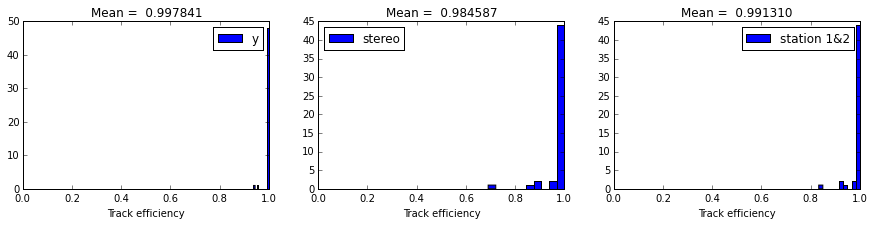

In [275]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

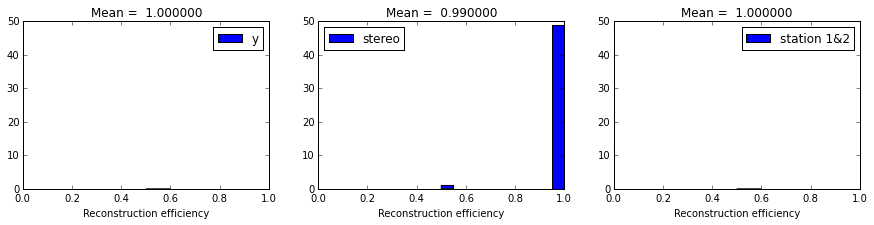

In [276]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Stations 3&4

### Y-views

In [277]:
tracks_metrics_after_y.mean(axis=0)

EventID      164.260000
AvgEff         0.990804
RecoEff        1.000000
GhostRate      0.020000
CloneRate      0.000000
dtype: float64

### Stereo-views

In [278]:
tracks_metrics_after_stereo.mean(axis=0)

EventID      164.260000
AvgEff         0.994182
RecoEff        0.980000
GhostRate      0.020000
CloneRate      0.000000
dtype: float64

### Station 3&4

In [279]:
tracks_metrics_after_all.mean(axis=0)

EventID      164.260000
AvgEff         0.992391
RecoEff        0.980000
GhostRate      0.020000
CloneRate      0.000000
dtype: float64

### Tracks efficiency

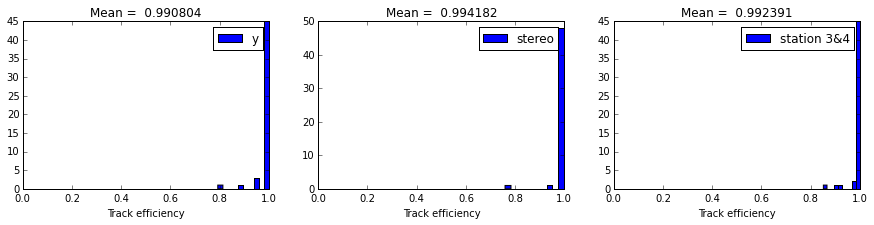

In [280]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

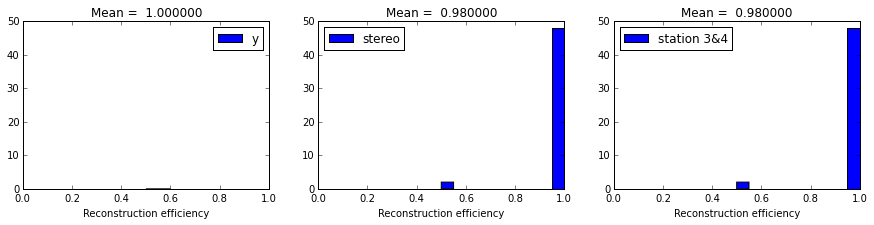

In [281]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Combination

In [282]:
combinations_quality.mean(axis=0)

EventID      164.26
RecoEff        0.97
GhostRate      0.00
CloneRate      0.00
NCombined      1.94
dtype: float64

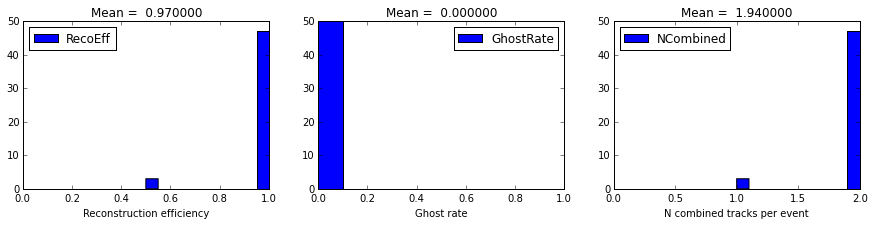

In [283]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff = combinations_quality.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff).mean())
plt.hist(eff, label='RecoEff')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
ghost = combinations_quality.GhostRate.values
plt.title('Mean = % f' % numpy.array(ghost).mean())
plt.hist(ghost, label='GhostRate')
plt.xlabel('Ghost rate')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
n_combined = combinations_quality.NCombined.values
plt.title('Mean = % f' % numpy.array(n_combined).mean())
plt.hist(n_combined, label='NCombined')
plt.xlabel('N combined tracks per event')
plt.xlim(0, 2)
plt.legend(loc='best')

plt.show()

# Ratio of the events passes through the stages

94.0


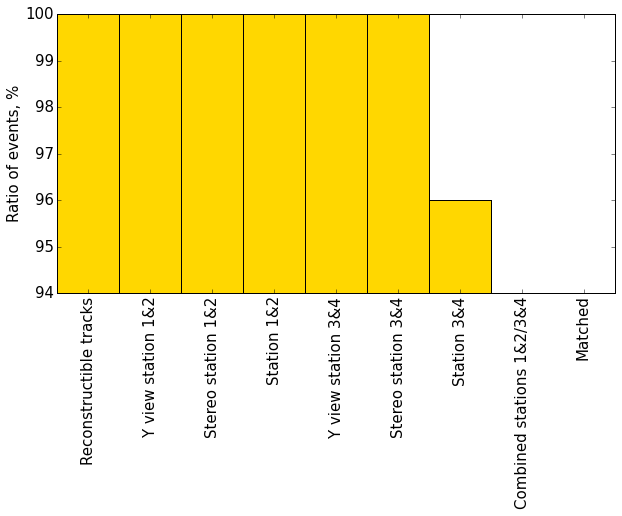

In [284]:
bar_labels = ['Reconstructible tracks', 
              'Y view station 1&2', 
              'Stereo station 1&2', 
              'Station 1&2',
              'Y view station 3&4', 
              'Stereo station 3&4',
              'Station 3&4',
              'Combined stations 1&2/3&4',
              'Matched']

bar_values = pass_stages[pass_stages.columns[1:]].sum(axis=0).values
bar_values = bar_values / bar_values[0] * 100


print bar_values[-1]

x = range(len(bar_labels))
plt.figure(figsize=(10,5))
plt.bar(x, bar_values, width=1., color='gold', align='center')
plt.xticks(x, bar_labels, rotation=90, size=15)
plt.yticks(size=15)
plt.xlim(-0.5, 8.5)
plt.ylim(bar_values[-1], bar_values[0])
plt.ylabel('Ratio of events, %', size=15)
plt.show()

In [285]:
bar_values

array([ 100.,  100.,  100.,  100.,  100.,  100.,   96.,   94.,   94.])

# Momentum

In [286]:
passed_events = event_ids[pass_stages.Matching.values == 1]
p_err = combinations_true[combinations_true.EventID.isin(passed_events)].PErr.values

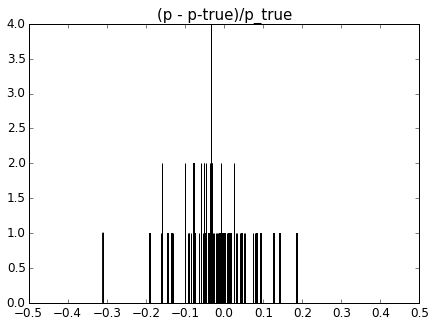

In [287]:
plt.figure(figsize=(7, 5))
plt.hist(p_err[numpy.isfinite(p_err)], bins=1000)

plt.title('(p - p-true)/p_true', size=15)
plt.xticks(numpy.arange(-0.5, 0.51, 0.1), size=12)
plt.yticks(size=12)
plt.xlim(-0.5, 0.5)
plt.show()

In [288]:
len(p_err) - len(p_err[numpy.isfinite(p_err)])

0

# Did not recognized tracks

In [289]:
pass_stages[pass_stages.Matching.values == 0]

,EventID,RecoEvents,Y12,Stereo12,Stations12,Y34,Stereo34,Stations34,Combination,Matching
6,270,1,1,1,1,1,1,0,0,0
7,143,1,1,1,1,1,1,0,0,0
34,85,1,1,1,1,1,1,1,0,0


In [290]:
bad_events = pass_stages[pass_stages.Matching.values == 0]['EventID'].values

270.0


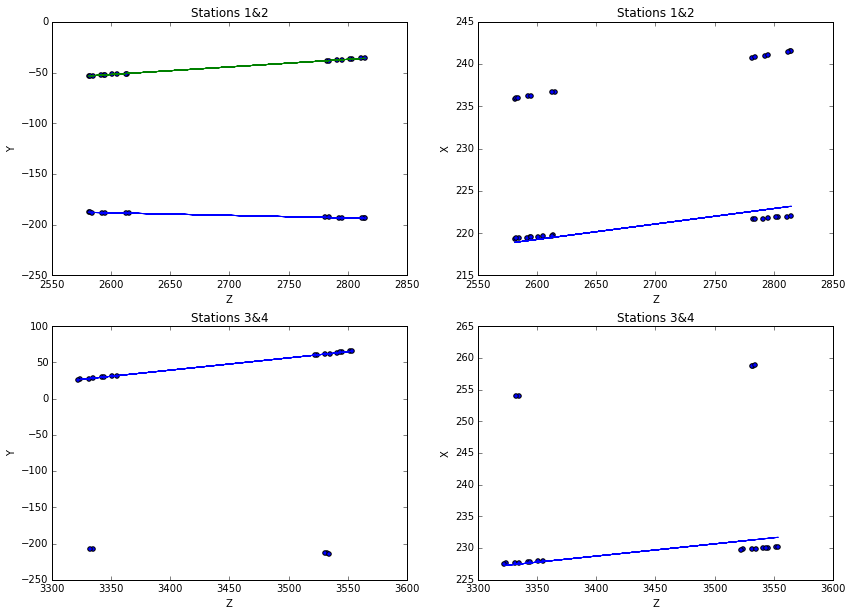

143.0


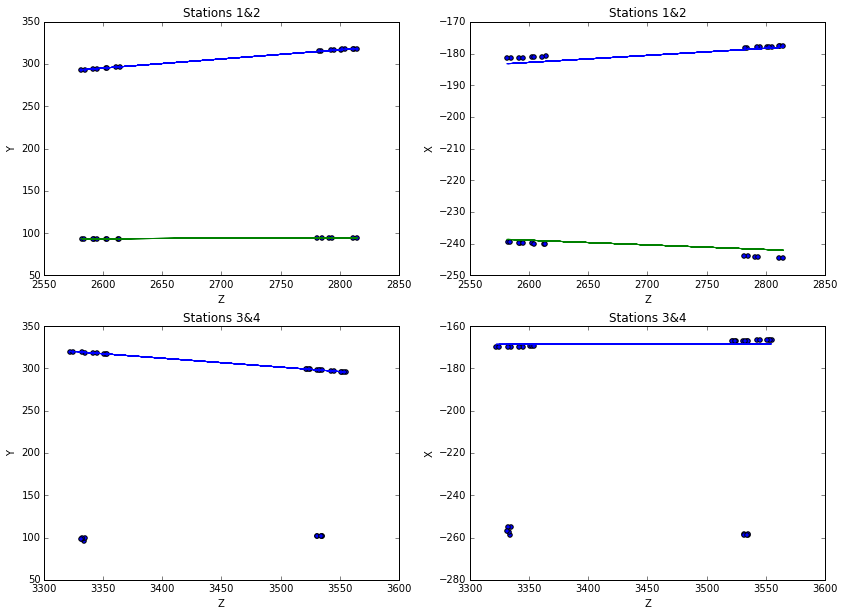

85.0


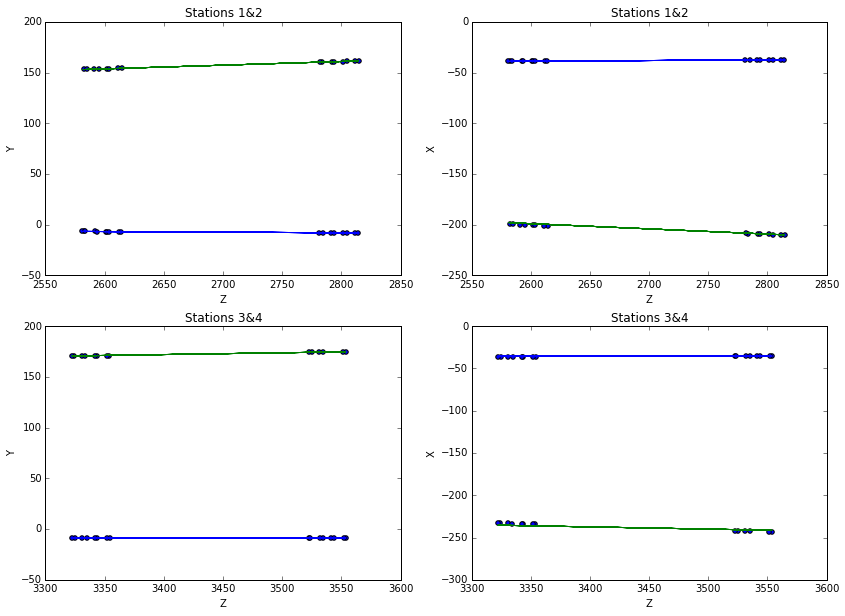

In [291]:
from utils import plot_event

for event_id in bad_events:
    print event_id
    plot_event(event_id, data, tracks)